In [1]:
!pip install torch torchvision opencv-python matplotlib


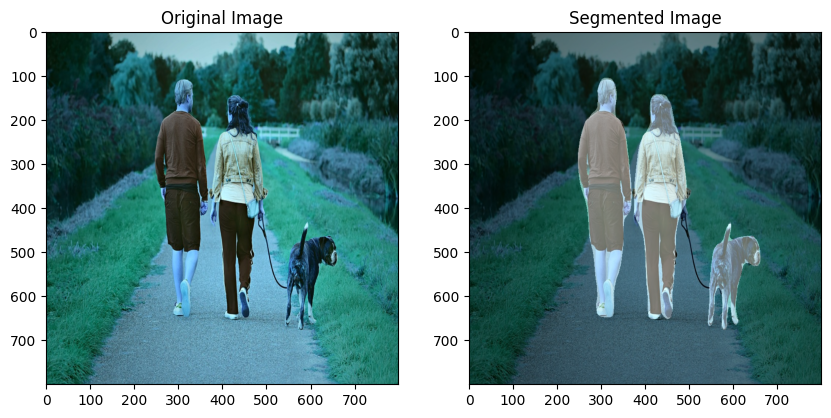

In [15]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Preprocess the image
def preprocess(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (800, 800))  # Resize to a standard size for Mask R-CNN

    preprocess_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    input_tensor = preprocess_transform(image_resized).unsqueeze(0)
    return input_tensor, image_resized

# Perform segmentation and post-process the output
def segment_image(model, input_tensor):
    with torch.no_grad():
        output = model(input_tensor)
        masks = output[0]['masks'].cpu().numpy()  # Get the masks from the output
        scores = output[0]['scores'].cpu().numpy()  # Get the scores
        # Keep only high-confidence detections
        high_confidence_masks = masks[scores > 0.5]
    return high_confidence_masks

# Function to overlay the segmentation mask on the original image
def overlay_segmentation_mask(image, masks):
    # Create an empty mask to combine all masks
    combined_mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    for mask in masks:
        # Convert the mask to a binary mask
        binary_mask = (mask[0, :, :] > 0.5).astype(np.uint8) * 255
        # Apply the mask to the image
        colored_mask = np.stack([binary_mask] * 3, axis=-1)  # Convert to 3 channels
        combined_mask = np.maximum(combined_mask, colored_mask)

    blended = cv2.addWeighted(image, 0.6, combined_mask, 0.4, 0)
    return blended

# Load the image and preprocess it
image_path = '/content/family-and-dog.jpg'  # Replace with your image path
input_tensor, image_resized = preprocess(image_path)

# Apply the segmentation model to the image
masks = segment_image(model, input_tensor)

# Overlay the segmentation mask on the original image
result_image = overlay_segmentation_mask(image_resized, masks)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image")

plt.show()
